AS.200.313, Models of Mind and Brain, Prof. Honey

Final Project, Gabriel Kressin Palacios

# How do Neural Networks learning with the plain Hebb rule, Hebb-Decay rule and Oja rule respectively compare to each other regarding accuracy, learning speed and other features in a digit classification task?

This project builds and compares three networks featuring biologically plausible learning rules to classify digits from the MNIST 10-digit dataset (LeCun, Y., & Cortes, C., & Burges, C.J.C.). How do these networks compare to each other regarding accuracy, learning speed and other features?

Neural Networks are very powerful machine learning tools, which currently are one of the most successfull models at predicting human brain activity (Yamins et al., 2014), whilst also achieving human-like performance and performance patterns in specific tasks (Serre, Oliva, & Poggio, 2007). Despite being biologically inspired, the most powerful methods to train Neural Networks rely on "backpropagation" - a process which is difficult to imagine taking place in the human brain (although that seems to be under dispute currently). Besides backpropagation, other learning rules exist which are insipired by biological processes such as Long Term Potentiation and thus seem to be more biologically plausible. This project builds three networks which only differ in those rules and compares them based on a 10-way 28x28 handwritten digit classification task. Following rules are used:

    1. Plain Hebbian rule.
    2. Hebbian-Decay rule.
    3. Oja's learning rule.

How do those learning rules compare to each other in classification accuracy? What could be one of the main differences making one effective and the other not? Furthermore, biological systems tend to be very efficient and effective in their learning capabilities, thus learning speed is taken into account into the comparison. Additionally, other emerging factors of the learning rules could lead to interesting properties in a biological system.

The project consists of 3 stages:

#### Stage 1: Definition
First, the network and learning rules are explained and defined. Additionally the data is loaded in and taken a look at.

#### Stage 2: Training & Exploration
Second, the networks are trained on the data and results are plotted. Based on the results additional investigations into learning speed and specific effects are made.

#### Stage 3: Conclusion
Finally, a conclusion is drawn based on the results and following three criteria:
- Classification accuracy
- Learning speed
- Emerging other factors

# Stage 1: Definition

In this stage the Neuron, learning rules and activation functions are defined. Furthermore this section includes all functions and the Data is loaded in.

## The Neuron

A neuron with the input $\mathbf{x}$ and the output $\mathbf{y}$ can be defined as

\begin{equation}
    \mathbf{y}  = f(\mathbf{wx})
\end{equation}

Whereas $\mathbf{w}$ is a vector of the weights of the input and $f$ is the so called 'activation function' - a potentially nonlinear function.

## The implementation

To make the computations more efficient, multiple Neurons are stacked together in a 'Layer'. In that case, multiple weight Vectors $\mathbf{w}$ are 'stacked' on top of each other creating a weight matrix $\mathbf{W}$ and the output becomes a vector of outputs.

The 'Layer' class below implements the above mentioned framework without specifying any details on activation function and how the neuron learns. The 'Layer' class takes learning rule and activation function as initializing arguments and then provides following functions:
- compute: computes the outputs of neurons in the layer
- learn: updates the weights for given samples
- getWeights: returns the weights object
- train: trains the Layer on a dataset

The code-cell below features all of the functions used in the project and is organized in this manner:
1. Imports
2. Functions used in classes
3. Classes
4. General Functions
5. Plotting Functions

The project was created in python 3.8.6; To load the project properly following dependencies are needed:
- matplotlib
- numpy

In [1]:
%matplotlib inline

# Imports

import copy
import gzip
import matplotlib.pyplot as plt
import numpy as np
import random


# Functions used in classes

def normalizeRows( x ):
    """
    Normalizes Rows, Frobenius norm
    """
    return x / np.linalg.norm( x, axis=1 )[ :, None ]


def softmax( x ):
    """
    Converts all values in vector x so that they add up to 1
    """
    xrel = x - np.max( x ) # Handle exploding Hebb Values
    return np.exp( xrel ) / np.sum( np.exp( xrel ), axis=0 )


def runTest( X, y, network, convertedy=None ):
    """
    Computes for given X and y data the amount of correct predictions by the given network.
    Requires the predictions being higher then 0.
    If there is multiple predictions with the same value, the lowest digit of those is taken.
    """
    # assert isinstance( network, Layer ) or isinstance( network, Network ), "Not given a 'Layer' or 'Network' object in network argument!"
    assert X.shape[0] == y.shape[0], "X shape does not match y shape!"

    # Convert Labels into digits
    if convertedy is None:
        y = asDigits( y )
    else:
        y = convertedy

    # Compute predictions
    preds = np.empty( y.shape )
    for i in range( X.shape[0] ):
        predvec = network.compute( X[i] )
        # Require predictions to be over 0
        if np.sum( predvec ) == 0:
            preds[i] = None
        else:
            preds[i] = np.argmax( softmax( predvec ) )

    # Compare
    comp = preds == y
    correct = sum( comp.astype( np.int ) ) / y.shape[0]
    indexWrong = np.where( comp == False )
    return correct, indexWrong


# Classes

class Layer():
    """
    A Layer object includes all neurons in a layer.
    It saves the weights in Matrix form.
    The weights can be updated whilst computing the results.
    """

    def __init__( self,
                    nInputs,
                    nNeurons,
                    activationFunction=( lambda x: x ),
                    learning=( lambda w, x, y, eta: w + eta * np.outer( y, x.T ) ),
                    random=False,
                    normalize=False ):
        """
        nInputs: amount of input neurons to layer
        nNeurons: amount of neurons in layer (==outputs)
        activationFunction: potentially nonlinear function for the activation of the neuron: standard: linear Neuron
        learning: learning Rule for Layers, standard: is simple Hebbian
        random: initialize weights randomly - will normalize weights to 1, standard: False
        normalize: should weights be normalized after every learning step, standard: False
        """
        self.layerShape = ( nNeurons, nInputs )
        self.aF = activationFunction
        self.learning = learning
        self.normalize = normalize

        if random:
            self.weights = normalizeRows( np.random.uniform( low=-1, high=1, size=self.layerShape ) )
        else:
            self.weights = np.zeros( self.layerShape )


    def setWeights( self, weights ):
        """
        Sets the Layers weights
        """
        assert self.weights.shape == weights.shape, "New Weights have wrong shape"
        self.weights = weights


    def getWeights( self ):
        """
        Gets the Layers weights
        """
        return self.weights


    def learn( self, x, y, eta=0.25 ):
        """
        X: input data
        y: output data
        eta: learning rate
        """
        self.weights = self.learning( self.weights, x, y, eta )
        if self.normalize:
            self.weights = normalizeRows( self.weights )
            # Deal with rows which where completely 0
            self.weights[ np.isnan( self.weights ) ] = 0


    def compulearn( self, x, y=None, eta=0.25 ):
        """
        Computes a Prediction with current weights from input x,
        Learns the weights depending on output:
        y: Label that should be learned, if None the computed result will be taken to learn
        """

        # 1. Compute Result
        res = self.compute( x )

        # 2. Learn the network
        if y is None:
            self.learn( x, res, eta )
        else:
            self.learn( x, y, eta )

        return res


    def compute( self, x ):
        """
        Computes a Prediction with current weights from imput x.
        """
        return self.aF( np.dot( self.weights, x ) )


    def train( self, Xt, yt, X_val, y_val, epochs, eta, permute, verbose=True, decay=1, decayAfter=1 ):
        """
        Trains the neural network on training set for given epochs
        Returns history of training accuracy over validation set for each epoch
        Xt, X_val: Data Training/Validation
        yt, y_val: Labels Training/Validation
        epochs: how often you go through entire training set
        eta: learning rate
        permute: train in order given by data or randomly permute it?
        verbose: print validation accuracy after epoch
        decayAfter: Number (0, 1] indicating after how much of the training set has passed the learning rate is decayed
        decay: the ratio with which the learning rate is decayed
        """
        assert Xt.shape[0] == yt.shape[0], "X shape does not match y shape!"
        assert X_val.shape[0] == y_val.shape[0], "X shape does not match y shape (Val Data)!"
        assert decayAfter <= 1 and decayAfter > 0, "Decay "

        hist = []

        # Set up decay
        idxDec = int( Xt.shape[0] * decayAfter )

        for x in range( epochs ):
            print( f"Epoch { x + 1 }: ", end='' )
            if permute:
                permutation = np.random.permutation( Xt.shape[0] )
            else:
                permutation = list( range( Xt.shape[0] ) )

            for i, idx in enumerate( permutation ):
                self.learn( Xt[idx], yt[idx], eta )
                if ( (i + 1) % idxDec ) == 0:
                    eta *= decay

            # Compute validation, save and print
            correct, _ = runTest( X_val, y_val, self )
            hist.append( correct )
            if verbose:
                print( f"Val: {correct:.4f} Eta: {eta}" )

            eta *= decay

        return hist


# General Functions

def runPrintTest( X, y, network, name="" ):
    """
    runs a test given X and y with network and prints the result,
    returns amount of correct classified elements and indices of wrong ones
    """
    correct, indicesWrong = runTest( X, y, network )
    print( f"{name} {correct}/{y.shape[0]} correct: { correct/y.shape[0] * 100 } %" )
    return correct, indicesWrong


def trainNewNetworksAndTest( X_train,
                            y_train,
                            X_val,
                            y_val,
                            X_test,
                            y_test,
                            runs,
                            epochs,
                            learningRules,
                            decayAfter=1,
                            decay=1,
                            permute=True,
                            N_INPUT=28*28,
                            N_OUTPUT=10,
                            eta=0.1,
                            verbose=True,
                            retNetworks=False
                           ):
    """
    Trains 3 new networks and returns dictionaries for accuracies, wrongly classified indices and
    history of Validationa accuracies for each epoch, run and network.
    X_train: Training data
    y_train: Training labels
    X_val: Validation data
    y_val: Validation labels
    X_test: Testing data
    y_test: Tesing labels
    decayAfter: Number (0, 1] indicating after how much of the training set has passed the learning rate is decayed
    decay: Decay learning coefficient eta by this rate, set to 1 for no decay
    runs: Divisible by 2, Amount of different testruns for each network
    epochs: Amount of iterations through testset for a single network
    learningRules: 3 learning rules to be used
    N_INPUT: input number of neurons
    N_OUTPUT: output number of neurons
    eta: learning rate
    retNetworks: whether networks should be returned or not
    """
    r_hebb, r_decay, r_ojas = learningRules
    # Create a dictionaries with all the networks and activationFunctions
    accuracies = { 'hebb': [], 'deca': [], 'ojas': [] }
    wrongIndices = { 'hebb': [], 'deca': [], 'ojas': [] }
    valHistory = { 'hebb': [], 'deca': [], 'ojas': [] }
    if retNetworks:
        networks = { 'hebb': [], 'deca': [], 'ojas': [] }
    else:
        networks = None

    for run in range( runs ):
        print( f"Run Number {run + 1}" )
        # Initialize Networks
        hebb = Layer( N_INPUT, N_OUTPUT, learning=r_hebb )
        deca = Layer( N_INPUT, N_OUTPUT, learning=r_decay )
        ojas = Layer( N_INPUT, N_OUTPUT, learning=r_ojas, normalize=True )
        # Train
        print( "Hebb" )
        np.random.seed( run )
        hisHebb = hebb.train( X_train, y_train, X_val, y_val, decayAfter=decayAfter, decay=decay, permute=permute, epochs=epochs, eta=eta, verbose=verbose )
        print( "Decay" )
        np.random.seed( run )
        hisDeca = deca.train( X_train, y_train, X_val, y_val, decayAfter=decayAfter, decay=decay, permute=permute, epochs=epochs, eta=eta, verbose=verbose )
        print( "Oja")
        np.random.seed( run )
        hisOjas = ojas.train( X_train, y_train, X_val, y_val, decayAfter=decayAfter, decay=decay, permute=permute, epochs=epochs, eta=eta, verbose=verbose )
        # Run test after training
        hebb_post_acc, hebb_post_iWrong = runTest( X_test, y_test, hebb )
        deca_post_acc, deca_post_iWrong = runTest( X_test, y_test, deca )
        ojas_post_acc, ojas_post_iWrong = runTest( X_test, y_test, ojas )
        # Save data in the dictionaries
        accuracies['hebb'].append( hebb_post_acc )
        accuracies['deca'].append( deca_post_acc )
        accuracies['ojas'].append( ojas_post_acc )
        wrongIndices['hebb'].append( hebb_post_iWrong )
        wrongIndices['deca'].append( deca_post_iWrong )
        wrongIndices['ojas'].append( ojas_post_iWrong )
        valHistory['hebb'].append( hisHebb )
        valHistory['deca'].append( hisDeca )
        valHistory['ojas'].append( hisOjas )
        if retNetworks:
            networks['hebb'].append( hebb )
            networks['deca'].append( deca )
            networks['ojas'].append( ojas )

    print( "Done" )
    return accuracies, wrongIndices, valHistory, networks


def readImages( path ):
    """
    Reads images from idx dataformat into np array
    Code partly from: https://stackoverflow.com/a/53570674
    """
    with gzip.open( path ) as f:
        f.read(4)   # Jump Magic Number
        nImages = int.from_bytes( f.read(4), "big" )
        x = int.from_bytes( f.read(4), "big" )
        y = int.from_bytes( f.read(4), "big" )
        print( f"Images: {nImages}; Size: x:{x}, y:{y};" )

        # Read the data in
        buf = f.read( x * y * nImages )
        data = np.frombuffer( buf, dtype=np.uint8 ).astype( np.int64 )
        return data.reshape( nImages, x * y )


def readLabels( path ):
    """
    Reads labels from idx dataformat into np aray
    Code partly from: https://stackoverflow.com/a/53570674
    """
    with gzip.open( path ) as f:
        f.read(4)   # Jump Magic Number
        nLabels = int.from_bytes( f.read(4), "big" )
        print( f"Labels: {nLabels};" )

        # Read the labels in
        buf = f.read( nLabels )
        labels = np.frombuffer( buf, dtype=np.uint8 ).astype( np.int64 )
        return labels


def printStats( xs, topFive=False ):
    """
    prints basic information about a numpy array along axis 1
    """
    if topFive:
        print( f"Top 5 entries:\n { xs[ 0:5 ] }" )
    print( f"Mean: { np.mean( xs, axis = 0 ) }" )
    print( f"Max : { np.amax( xs, axis = 0 ) }" )
    print( f"Min : { np.amin( xs, axis = 0 ) }" )


def asDigits( labels ):
    """
    Turns One-Hot-Vector encodings to digits, returns a numpy array
    """
    return np.argmax( labels, axis=1 )


def accDuringLearning( X, y, X_test, y_test, runs, lRs, stepSize, eta, N_INPUT=28 * 28, N_OUTPUT=10 ):
    """
    Trains a network for data and checks every stepSize accuracy on given testset
    Result is a tuple (resultDict, xs),
    whereas dict  has shape (learningRules, runs, XresultLength)
    and xs is an array of integers for which testdata has been collected
    """
    resultLength = int( X.shape[0] / stepSize )
    y_testDigits = asDigits( y_test )

    res = { lR: [] for lR in lRs }
    for r in range( runs ):
        print( f"Run {r}" )

        # Init networks and result arraays
        networks = dict()
        for lR in lRs:
            # Network
            if lR == "Oja":
                networks[lR] = Layer( N_INPUT, N_OUTPUT, learning=lRs[lR], normalize=True )
            else:
                networks[lR] = Layer( N_INPUT, N_OUTPUT, learning=lRs[lR] )
            # Results
            res[lR].append( np.zeros( resultLength + 1 ) )
        xs = [0] * ( resultLength + 1 )

        # Train and test networks
        rcount = 1
        for i, idx in enumerate( np.random.permutation( X.shape[0] ) ):
            for lR in lRs:
                networks[lR].learn( X[idx], y[idx], eta=eta )
            if ( i % N == 0 ):
                for lR in lRs:
                    res[lR][-1][rcount], _ = runTest( X_test, y_test, networks[lR], y_testDigits )
                xs[rcount] = i
                rcount += 1
            if ( i % ( X.shape[0] // 10 ) == 0 ):
                print( "+", end="" )
        print( "" )
    return res, xs


def accDuringTrainingEpochs( Xt,
                            yt,
                            X_te,
                            y_te,
                            runs,
                            epochs,
                            lRs,
                            stepSize,
                            eta=0.1,
                            decayAfter=1.0,
                            decay=1.0,
                            N_INPUT=28 * 28,
                            N_OUTPUT=10
                           ):
    """
    Trains a network and monitors accuracy on given test data at the same time
    Returns a dict with shape (learningRules, runs, XresultLength),
      an array xs with x values at points at which accuracies where collected,
      the offset at which data collection started
    Xt, X_te: Data Training/test
    yt, y_te: Labels Training/test
    runs: amount of trial runs
    epochs: how often you go through entire training set
    lRs: learning rules
    easter: egg :o
    stepSize: how many training examples until accuracy is checked
    eta: learning rate
    decayAfter: Number (0, 1] indicating after how much of the training set has passed the learning rate is decayed
    decay: the ratio with which the learning rate is decayed
    """
    offset = Xt.shape[0] % stepSize
    resultLength = int( Xt.shape[0] / stepSize )
    results = { lR: [] for lR in lRs }

    # Set up decay
    idxDec = int( Xt.shape[0] * decayAfter )

    y_teD = asDigits( y_te )

    for r in range( runs ):
        print( f"Run {r}" )

        # Init networks and result datastructures
        networks = dict()
        for lR in lRs:
            # Network
            if lR == "Oja":
                networks[lR] = Layer( N_INPUT, N_OUTPUT, learning=lRs[lR], normalize=True )
            else:
                networks[lR] = Layer( N_INPUT, N_OUTPUT, learning=lRs[lR] )
            # Results
            results[lR].append( np.zeros( resultLength * epochs + 1 ) )
        xs = [0] * ( resultLength * epochs + 1 )

        # Train and test networks
        rcount = 1
        # Reset eta
        tEta = eta
        for e in range( epochs ):
            print( f"--Epoch {e + 1}" )
            for i, idx in enumerate( np.random.permutation( Xt.shape[0] ) ):
                # Train Network
                for lR in lRs:
                    networks[lR].learn( Xt[idx], yt[idx], eta=tEta )
                # Evaluate Network
                if ( ( i + offset ) % stepSize == 0 ):
                    for lR in lRs:
                        results[lR][-1][rcount], _ = runTest( X_te, y_te, networks[lR], y_teD )
                    # Add x for plot later
                    xs[rcount] = ( X_train.shape[0] * e ) + i
                    rcount += 1
                # Display "+" for impatient people
                if ( i % ( Xt.shape[0] * 0.1 ) == 0 ):
                    print( "+", end="" )
                # Decay
                if ( ( i + 1) % idxDec ) == 0:
                    tEta *= decay
            print( "" )

    return results, xs, offset


def computeAccPerLabel( y, wrongIndices ):
    """
    Computes Accuracy for given testset y and wrongly marked indices
    """
    y = asDigits( y )
    bins = [0,1,2,3,4,5,6,7,8,9,10]
    distr, _ = np.histogram( y, bins )

    # Get labels for wrong indices
    wrongIndiceLabels = y[wrongIndices]
    wrongs, _ = np.histogram( wrongIndiceLabels, bins )

    return ( distr - wrongs ) / distr


def plotData( images, labels, n ):
    """
    Prints n random images with their labels from given images
    Code adapted from: https://azure.microsoft.com/de-de/services/open-datasets/catalog/mnist/
    """
    # Get images in right format:
    images = np.reshape( images, ( images.shape[0], 28, 28 ) )
    # Convert labels to digits:
    labels = asDigits( labels )
    plt.figure( figsize=( 16, 6 ) )
    for i, x in enumerate( np.random.permutation( images.shape[0] )[:n] ):
        plt.subplot( 1, n, i + 1 )
        plt.axhline( "" )
        plt.axvline( "" )
        plt.text( x=10, y=-10, s=labels[x], fontsize=21 )
        plt.imshow( images[x], cmap=plt.cm.Greys )


# Plotting Functions

def plotDistribution( labels, title="" ):
    """
    Plots distribution of digits in dataset
    Code from: https://stackoverflow.com/a/51475132
    and https://stackoverflow.com/a/53073502
    """
    bins = [0,1,2,3,4,5,6,7,8,9,10]
    heights, _ = np.histogram( asDigits( labels ), bins )
    percent = [ i / sum( heights ) * 100 for i in heights ]

    f, ax = plt.subplots( 1, 1 )
    ax.bar( bins[:-1], percent, width=0.8, color="grey" )
    ax.set_ylim( [0, 15] )

    # axis labels
    ax.set_ylabel( "Percentage of entire dataset in %" )
    ax.set_xlabel( "image labels" )

    # x ticks
    ax.set_xticks( bins[:-1] )

    # numbers above bars
    for i, v in enumerate( percent ):
        plt.text( bins[i] - 0.4, v + 0.4, f"{v:.2f}%", rotation=45)
    plt.title( title )
    plt.show()


def plotNumberAcc( percentHebb, percentDeca, percentOjas, title ):
    """
    Plots given percentages in bar Graph for numbers 0 to 9
    """
    width = 1
    bins = np.array( range(11) )

    f, ax = plt.subplots( 1, 1, figsize=(15, 5) )
    ax.bar( bins[:-1] * 4, percentHebb, width=width )
    ax.bar( bins[:-1] * 4 + width, percentDeca, width=width )
    ax.bar( bins[:-1] * 4 + width * 2, percentOjas, width=width )
    ax.set_ylim( [0, 115] )

    # axis labels
    ax.set_ylabel( "Accuracy in %" )
    ax.set_xlabel( "image labels" )

    # x ticks
    ax.set_xticks( bins[:-1] * 4 + width )
    ax.set_xticklabels( bins[:-1] )

    # numbers above bars
    offsetx = -0.2
    offsety = 1.5
    for i, v in enumerate( percentHebb ):
        plt.text( bins[i] * 4 + offsetx, v + offsety, f"{v:.2f}%", rotation=90, fontsize=9 )
    for i, v in enumerate( percentDeca ):
        plt.text( bins[i] * 4 + width + offsetx, v + offsety, f"{v:.2f}%", rotation=90, fontsize=9 )
    for i, v in enumerate( percentOjas ):
        plt.text( bins[i] * 4 + width * 2 + offsetx, v + offsety, f"{v:.2f}%", rotation=90, fontsize=9 )

    plt.legend( ["Hebbian", "Decay", "Oja"] )
    plt.title( title )
    plt.show()


def plotNumberAccFromWrong( y, idxWrongDic, run, title ):
    """
    Plots a bar graph with labels on x axis and accuracy on y axis for given testset and
        wrongly classified indices
    """
    percentHebb = computeAccPerLabel( y, idxWrongDic['hebb'][run] ) * 100
    percentDeca = computeAccPerLabel( y, idxWrongDic['deca'][run] ) * 100
    percentOjas = computeAccPerLabel( y, idxWrongDic['ojas'][run] ) * 100

    plotNumberAcc( percentHebb, percentDeca, percentOjas, title )


def plotAvgNumberAccFromWrong( y, idxWrongDic, title ):
    """
    Plots bar graph of average accuracy per label in testset y
    given dictionary of wrong indices
    """
    accs = { lR: [] for lR in idxWrongDic }
    for lR in idxWrongDic:
        for run in range( len( idxWrongDic[lR] ) ):
            accs[lR].append( computeAccPerLabel( y, idxWrongDic[lR][run] ) * 100 )

    plotNumberAcc( np.average( accs['hebb'], axis=0 ),
                  np.average( accs['deca'], axis=0 ),
                  np.average( accs['ojas'], axis=0 ),
                  title
                 )


def plotAccuracies( accs, learningRuleNames, title ):
    plt.figure( figsize=( 10, 7 ) )
    plt.title( title )
    plt.ylim( [0, 100] )
    bWidth = 0.8
    xs = range( len( accs ) )

    percent = [ x * 100 for x in accs ]
    # plot the bars
    bars = plt.bar( xs, percent , width=bWidth, align='center' )

    # Colors
    bars[1].set_color( 'orange' )
    bars[2].set_color( 'green' )

    # Set x axis and labels
    plt.xticks( xs, learningRuleNames )
    plt.xlabel( 'Learning Rules' )
    plt.ylabel( 'Accuracy in %' )

    # numbers above bars
    for i, v in enumerate( percent ):
        plt.text( xs[i] - 0.09, v + 0.7, f"{v:.2f}%" )


def plotLineGraph( dic, title, xlabel, ylabel, lRs, ticks=0, offset=0, xs=None, legend=True ):
    """
    Takes dict as input, plots line graph
    """
    plt.figure( figsize=( 10, 7 ) )
    plt.title( title )
    plt.ylim( [0, 100] )
    if xs is None:
        xs = np.array( range( 0, len( list( dic.values() )[0] ) ) ) * ticks + offset

    for lR in lRs:
        plt.plot( xs, np.array( dic[lR] ) * 100, label=lR )

    # Axes
    plt.xlabel( xlabel )
    plt.ylabel( ylabel )
    plt.grid( True, axis="y" )

    # Legend
    if legend:
        plt.legend( lRs.keys() );


def plotWeights( weights ):
    """
    Prints n random images with their labels from given images
    Code adapted from: https://azure.microsoft.com/de-de/services/open-datasets/catalog/mnist/
    """
    # Get weights in right format:
    weights = np.reshape( weights, ( weights.shape[0], 28, 28 ) )
    # Convert labels to digits:
    labels = list( range( 10 ) )
    plt.figure( figsize=( 16, 2.5 ) )
    for i in range( weights.shape[0] ):
        plt.subplot( 1, len( labels ), i + 1 )
        plt.axhline( "" )
        plt.axvline( "" )
        plt.text( x=11, y=-4, s=labels[i], fontsize=21 )
        plt.imshow( weights[i], vmax=np.max( weights ) )

## Learning rules

The learning rules define how exactly a neuron updates its weights given a specific input and output. The learning rules in this project are 'biologically plausible'. That means they mimick processes of biological systems in some meaningful way, in this case it is mainly the locality of the learning rule.

#### Learning rate

All learning rules are multiplied by a factor $\eta$ - the learning rate. This factor decides how strongly the weights are influenced by a single training example. Throughout training, this factor often is decayed by a "decaying rate" - another factor which decides how much $\eta$ decreases after a certain amount of time. This is helpful to stabilize the networks throughout time.

### Plain Hebb rule

Hebbs rule (Hebb D.O. 1949) can be summarized as "What fires together, wires together".
The weights $\mathbf{W}$ are updated according to the given input, if the neuron was supposed to be activated. In other words, given a pair $(\mathbf{x}, \mathbf{y})$ the updated weights $\mathbf{\hat{W}}$ are computed:

\begin{equation}
\mathbf{\hat{W}} = \mathbf{W} + \eta \mathbf{y}\mathbf{x}^{T}
\end{equation}

### Hebb with decay rule

Hebbs plain Rule has a big drawback: the weights explode indefinitly to infinity. To stop that from happening a decay term is introduced (Amato et al. 2019, p.3). This leads to following equation:

\begin{equation}
\mathbf{\hat{W}} = \mathbf{W} + \eta \mathbf{y}( \mathbf{x} - \mathbf{W} )
\end{equation}

### Oja's Rule

Another way to stop the weight explosion is by normalizing the weights of each neuron to 1. Additionally the 'forgetting' part is limited to the correct outputs. This gives rise to Oja's rule (Oja E. 1982). Oja's rule defines:

\begin{equation}
\mathbf{\hat{W}} = \mathbf{W} + \eta \mathbf{y}( \mathbf{x} - \mathbf{y} \mathbf{W} )
\end{equation}

### Learning rules in Python

Finally, the implementation of the rules in Python! For this project the learning rules are implemented as lambda functions. It is important to keep in mind that they need to work for multiple Neurons stacked on top of each other.

In [2]:
# Learning rules in Python
r_hebb = lambda W, x, y, eta: W + eta * np.outer( y, x.T )
r_decay = lambda W, x, y, eta: W + eta * ( ( x - W ) * y[ :, None ] )
r_ojas = lambda W, x, y, eta: W + eta * ( ( x - W * y[ :, None ] ) * y[ :, None ] )

learningRules = ( r_hebb, r_decay, r_ojas, )
learningRuleNames = ( "Hebbian", "Decay", "Oja", )
lRs = { "Hebbian": r_hebb, "Decay": r_decay, "Oja": r_ojas }

## Activation function

For correctness of the above mentioned learning rules a linear Neuron is assumed.

\begin{equation}
    f(x) = x
\end{equation}

To evaluate the output of all neurons, the output vector  of all activations $\mathbf{y}$ is fed through a softmax which converts them to a value between 0 and 1, so that they all sum together to 1.

\begin{equation}
    f(y_i) = \frac{e^{y_i}}{\sum_y e^{y}}
\end{equation}

## The Data

The MNIST Database provides 60.000 training examples and 10.000 test examples without needing to preprocess or format them.

First, the data needs to be loaded in. There is three things to keep in mind:
- The labels are converted into One-Hot-Encodings. ( e.g. 1 -> [0,1,0,0,...], 2 -> [0,0,1,0,...] )
- The images have pixel values from 0 to 255, so the data is divided by 255 to have all data between 0 and 1.
- 92% of the training examples will be used for training, 8% for validation during training

In [3]:
# Load Training Data
print( "Train & Validation" )
data = ( readImages( "data/train-images-idx3-ubyte.gz" ) / 255 )
labels = np.array( [ np.array( [ 1 if x == label else 0 for x in range(10) ] ) for label in readLabels( "data/train-labels-idx1-ubyte.gz" ) ] )

# Pick last 8% as validation dataset
lindex = int( data.shape[0] * 0.92 )
X_train = data[:lindex]
y_train = labels[:lindex]
X_val = data[lindex:]
y_val = labels[lindex:]
y_valDigits = asDigits( y_val )

# Load Test Data
print( "\nTest" )
X_test = ( readImages( "data/t10k-images-idx3-ubyte.gz" ) / 255 )
y_test = np.array( [ np.array( [ 1 if x == label else 0 for x in range(10) ] ) for label in readLabels( "data/t10k-labels-idx1-ubyte.gz" ) ] )
y_testDigits = asDigits( y_test )

Train & Validation
Images: 60000; Size: x:28, y:28;
Labels: 60000;

Test
Images: 10000; Size: x:28, y:28;
Labels: 10000;


This is how the train data looks like:

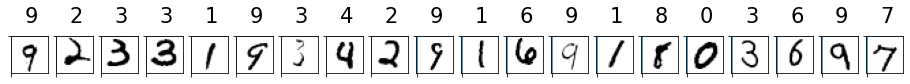

In [4]:
plotData( X_train, y_train, 20 )

Validation Data:

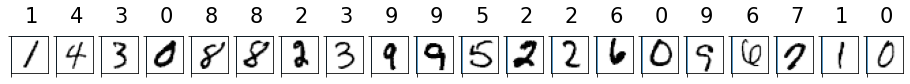

In [5]:
plotData( X_val, y_val, 20 )

Lastly, the test data:

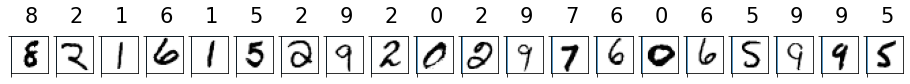

In [6]:
plotData( X_test, y_test, 20 )

The numbers are distributed as followed for all data sets:

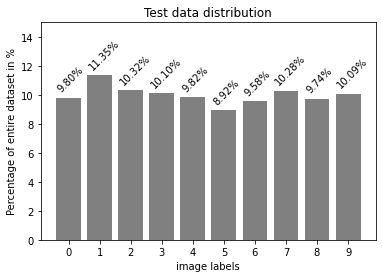

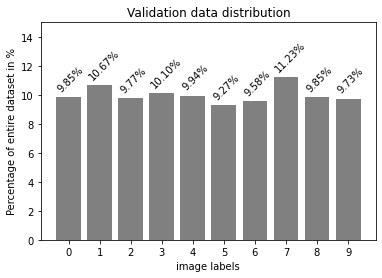

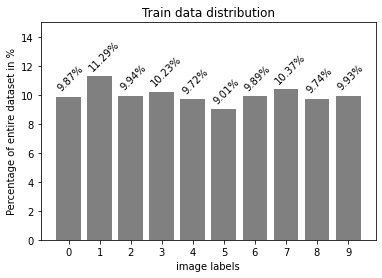

In [7]:
plotDistribution( y_test, "Test data distribution" )
plotDistribution( y_val, "Validation data distribution" )
plotDistribution( y_train, "Train data distribution" )

The training data is split into different numbers for later:

In [8]:
# Split training data into different numbers
numsData = []
numsLabels = []
dig = asDigits( y_train )
for i in range( 10 ):
    numsData.append( X_train[dig == i] )
    numsLabels.append( y_train[dig == i] )

# Stage 2: Training & Exploration

In this section the three learning rules are used to train networks. The accuracies are displayed, the learning speed is analyzed and the classification accuracy of the "5" is explored.

### First training

Three networks are initialized to weights of 0 and trained on the same random permutation of the training data for 10 epochs. This is repeated in 5 runs.

The learning rate $\eta$(eta) is set to 0.1, the decay factor to 0.4 and the learning rate decay happens after an entire epoch has passed.

Note: there is a runtime warning which does not affect the outcome of the training.

In [9]:
# Warning! This may takes some time to compute! (Epochs=5, runs=10 ~ 10 mins)
runsFirst = 10     # Amount of trial runs
epochsFirst = 5   # Amount of iterations on testset
accuracies, wrongIndices, valHistory, _ = trainNewNetworksAndTest( X_train,
                                                               y_train,
                                                               X_val,
                                                               y_val,
                                                               X_test,
                                                               y_test,
                                                               runsFirst,
                                                               epochsFirst,
                                                               learningRules,
                                                               eta=0.1,
                                                               decay=0.4,
                                                               decayAfter=1
                                                              )

Run Number 1
Hebb
Epoch 1: Val: 0.7117 Eta: 0.04000000000000001
Epoch 2: Val: 0.7117 Eta: 0.006400000000000002
Epoch 3: Val: 0.7117 Eta: 0.0010240000000000004
Epoch 4: Val: 0.7117 Eta: 0.00016384000000000008
Epoch 5: Val: 0.7117 Eta: 2.6214400000000015e-05
Decay
Epoch 1: Val: 0.5771 Eta: 0.04000000000000001
Epoch 2: Val: 0.6177 Eta: 0.006400000000000002
Epoch 3: Val: 0.6598 Eta: 0.0010240000000000004
Epoch 4: Val: 0.6573 Eta: 0.00016384000000000008
Epoch 5: Val: 0.6575 Eta: 2.6214400000000015e-05
Oja
Epoch 1: 

<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


Val: 0.6348 Eta: 0.04000000000000001
Epoch 2: Val: 0.7977 Eta: 0.006400000000000002
Epoch 3: Val: 0.8560 Eta: 0.0010240000000000004
Epoch 4: Val: 0.8590 Eta: 0.00016384000000000008
Epoch 5: Val: 0.8573 Eta: 2.6214400000000015e-05
Run Number 2
Hebb
Epoch 1: Val: 0.7117 Eta: 0.04000000000000001
Epoch 2: Val: 0.7117 Eta: 0.006400000000000002
Epoch 3: Val: 0.7117 Eta: 0.0010240000000000004
Epoch 4: Val: 0.7117 Eta: 0.00016384000000000008
Epoch 5: Val: 0.7117 Eta: 2.6214400000000015e-05
Decay
Epoch 1: Val: 0.5760 Eta: 0.04000000000000001
Epoch 2: Val: 0.6635 Eta: 0.006400000000000002
Epoch 3: Val: 0.6621 Eta: 0.0010240000000000004
Epoch 4: Val: 0.6615 Eta: 0.00016384000000000008
Epoch 5: Val: 0.6617 Eta: 2.6214400000000015e-05
Oja
Epoch 1: Val: 0.6202 Eta: 0.04000000000000001
Epoch 2: Val: 0.7727 Eta: 0.006400000000000002
Epoch 3: Val: 0.8333 Eta: 0.0010240000000000004
Epoch 4: Val: 0.8577 Eta: 0.00016384000000000008
Epoch 5: Val: 0.8569 Eta: 2.6214400000000015e-05
Run Number 3
Hebb
Epoch 1

The runs are averaged...

In [10]:
# Average the accuracies
avgAccs = dict()
for network in accuracies.keys():
    avgAccs[network] = np.average( accuracies[network] )

# Average the epoch accuracies
avgValHis = dict()
for network in valHistory.keys():
    avgValHis[network] = np.average( valHistory[network], axis=0 )

...and then visualized:

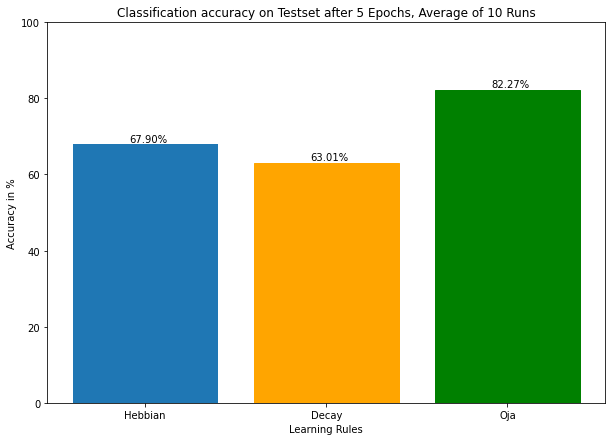

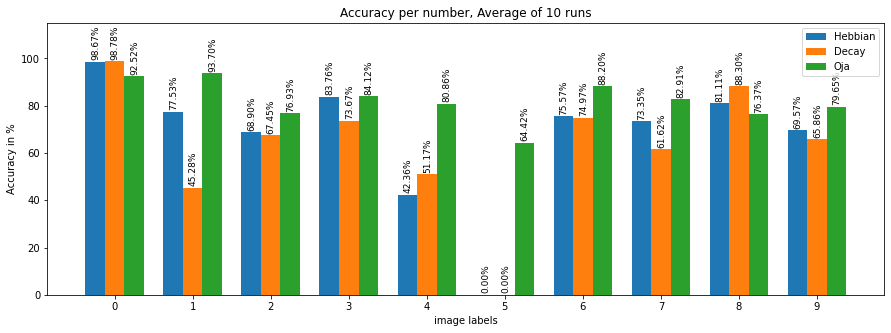

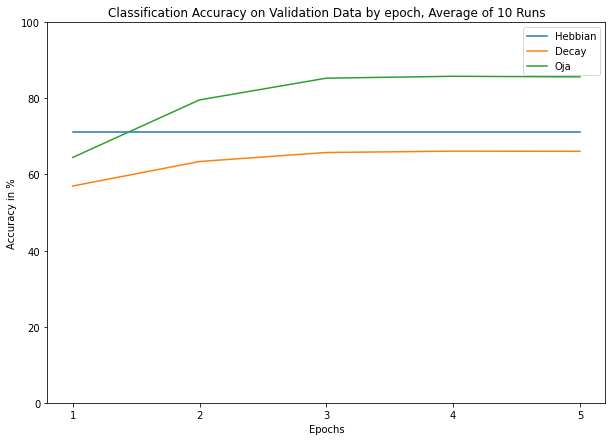

In [11]:
# Testset accuracy
plotAccuracies( avgAccs.values(), learningRuleNames, f"Classification accuracy on Testset after {epochsFirst} Epochs, Average of {runsFirst} Runs" )

# Accuracy per number
plotAvgNumberAccFromWrong( y_test, wrongIndices, f"Accuracy per number, Average of {runsFirst} runs" )

# Validation accuracy throughout epochs
plt.figure( figsize=( 10, 7 ) )
plt.title( f"Classification Accuracy on Validation Data by epoch, Average of {runsFirst} Runs" )
plt.ylim( [0, 100] )
xsFirst = range( 1, epochsFirst + 1 )

plt.plot( xsFirst, np.array( avgValHis['hebb'] ) * 100 )
plt.plot( xsFirst, np.array( avgValHis['deca'] ) * 100 )
plt.plot( xsFirst, np.array( avgValHis['ojas'] ) * 100 )

# Axes
plt.xlabel( 'Epochs' )
plt.xticks( xsFirst )
plt.ylabel( 'Accuracy in %' )

# Legend
plt.legend( learningRuleNames );

Since the average of the classification accuracy on validation data could hide certain effects, it is plotted individually as well:

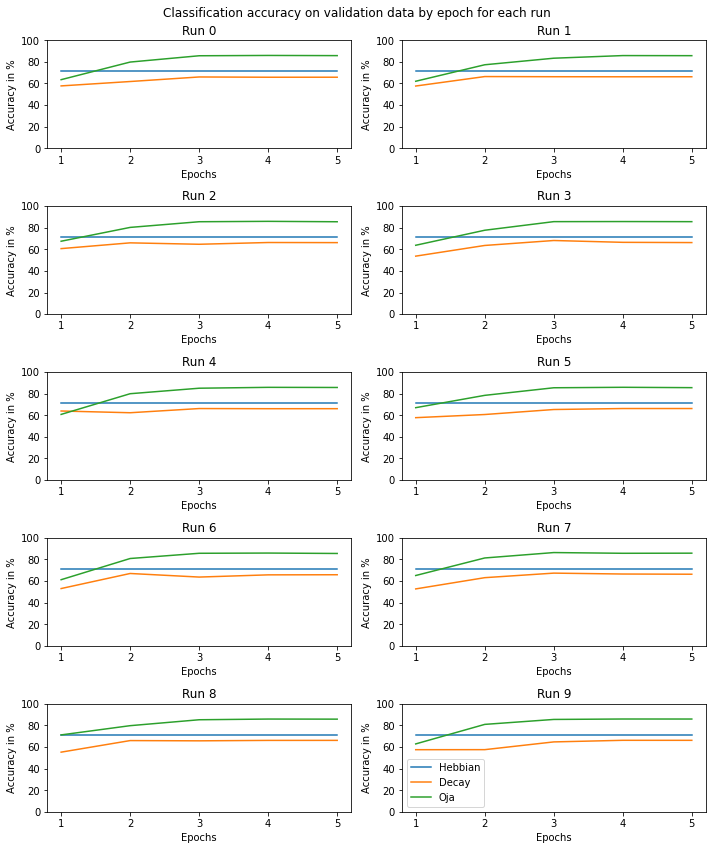

In [12]:
# Run Validation accuracy throughout epochs
plt.figure( figsize=( 10, 12 ) )
xsSec = range( 1, epochsFirst + 1 )

for r in range( runsFirst ):
    plt.subplot( int( runsFirst / 2 ), 2, r + 1 )
    plt.ylim( [0, 100] )
    plt.plot( xsSec, np.array( valHistory['hebb'][r] ) * 100 )
    plt.plot( xsSec, np.array( valHistory['deca'][r] ) * 100 )
    plt.plot( xsSec, np.array( valHistory['ojas'][r] ) * 100 )
    plt.title( f"Run {r}" )

    # Axes
    plt.xlabel( 'Epochs' )
    plt.xticks( xsSec )
    plt.ylabel( 'Accuracy in %' )

# Legend
plt.suptitle( "Classification accuracy on validation data by epoch for each run" )
plt.legend( learningRuleNames )
plt.tight_layout();

There are some interesting observations for these results:
1. The Oja network has the best accuracy
2. The Hebbian network has a steady accuracy from the first epoch on
3. The Hebbian and the Decay rule have difficulties classifying the 5.
4. The Decay rule shows great variability in classification accuracy on the validation set

The second observation is easily explained: Whereas the other rules have some sort of "forgetting" term, the plain Hebbian rule only adds input to expected output relations to the weights. Because these are independent on the current weights of the network, and because addition is associative, the order of training examples does not matter. This is also the reason the accuracy for the plain Hebbian network stays very similar through time, as after each epoch the weights just changed in similar proportions as in the epoch before, just with a different learning rate.

## Learning Speed Comparison

The Hebbian network performs at maximal classification accuracy just after one epoch. But how much faster exactly does the Hebbian network learn?
Furthermore, could the learning rate and decay could be tweaked so that the networks learn faster?

To answer the question an Ojas, Decay and Hebbian networks are trained in the same random order. To monitor their learning speed after every N steps they are tested on the test-dataset.

In [13]:
runsLS1 = 1
epochsLS1 = 3
etaLS1 = 0.1
decayLS1 = 0.4
stepSizeLS1 = 1000

resultsLS1, xsLS1, offsetLS1 = accDuringTrainingEpochs( X_train,
                                              y_train,
                                              X_val,
                                              y_val,
                                              runsLS1,
                                              epochsLS1,
                                              lRs,
                                              stepSizeLS1,
                                              eta=etaLS1,
                                              decay=decayLS1
                                             )

Run 0
--Epoch 1
+

<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


+++++++++
--Epoch 2
++++++++++
--Epoch 3
++++++++++


In [14]:
# Average results
avgResultsLS1 = dict()
for lR in resultsLS1:
    avgResultsLS1[lR] = np.average( resultsLS1[lR], axis=0 )

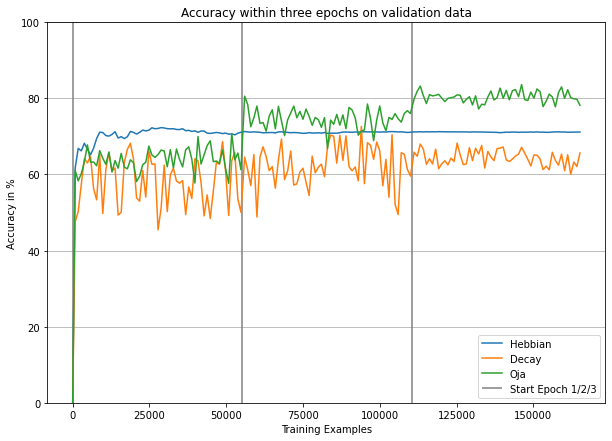

In [15]:
# Plot results
plotLineGraph( avgResultsLS1, "Accuracy within three epochs on validation data", "Training Examples", "Accuracy in %", lRs, stepSizeLS1, offsetLS1, xsLS1, False )
plt.vlines( 0, 0, 100, color="grey", label="Start Epoch 1/2/3" )
for i in range( 1, epochsLS1 ):
    plt.vlines( X_train.shape[0] * i, 0, 100, color="grey" )
plt.legend( loc='lower right' );

This result was quite surprising to me, it shows that the Oja and Decay network almost instantly have quite a high  accuracy and then just oscillate strongly. Only after a new epoch starts and the learning rate decreases the networks become better at classifying. That definitely means decaying the learning rate after an entire epoch is to late and additionally suggests that the learning rate is to high. But when exactly and with which learning rate do the networks reach their best accurcay?

To observe better how fast the Decay and Oja network learn, a closer look at the first 15000 training examples and the classification accuracy is taken with different learning rates. The learning rates explored are: \[0.8, 0.4, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001\]

Eta 1/10: 0.8, Run 0


<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


++++++++++
Run 1
++++++++++
Run 2
++++++++++
Run 3
++++++++++
Run 4
++++++++++
Run 5
++++++++++
Run 6
++++++++++
Run 7
++++++++++
Run 8
++++++++++
Run 9
++++++++++
Eta 2/10: 0.4, Run 0


<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


++++++++++
Run 1
++++++++++
Run 2
++++++++++
Run 3
++++++++++
Run 4
++++++++++
Run 5
++++++++++
Run 6
++++++++++
Run 7
++++++++++
Run 8
++++++++++
Run 9
++++++++++
Eta 3/10: 0.2, Run 0


<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


++++++++++
Run 1
++++++++++
Run 2
++++++++++
Run 3
++++++++++
Run 4
++++++++++
Run 5
++++++++++
Run 6
++++++++++
Run 7
++++++++++
Run 8
++++++++++
Run 9
++++++++++
Eta 4/10: 0.1, Run 0


<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


++++++++++
Run 1
++++++++++
Run 2
++++++++++
Run 3
++++++++++
Run 4
++++++++++
Run 5
++++++++++
Run 6
++++++++++
Run 7
++++++++++
Run 8
++++++++++
Run 9
++++++++++
Eta 5/10: 0.05, Run 0


<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


++++++++++
Run 1
++++++++++
Run 2
++++++++++
Run 3
++++++++++
Run 4
++++++++++
Run 5
++++++++++
Run 6
++++++++++
Run 7
++++++++++
Run 8
++++++++++
Run 9
++++++++++
Eta 6/10: 0.01, Run 0


<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


++++++++++
Run 1
++++++++++
Run 2
++++++++++
Run 3
++++++++++
Run 4
++++++++++
Run 5
++++++++++
Run 6
++++++++++
Run 7
++++++++++
Run 8
++++++++++
Run 9
++++++++++
Eta 7/10: 0.005, Run 0


<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


++++++++++
Run 1
++++++++++
Run 2
++++++++++
Run 3
++++++++++
Run 4
++++++++++
Run 5
++++++++++
Run 6
++++++++++
Run 7
++++++++++
Run 8
++++++++++
Run 9
++++++++++
Eta 8/10: 0.001, Run 0


<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


++++++++++
Run 1
++++++++++
Run 2
++++++++++
Run 3
++++++++++
Run 4
++++++++++
Run 5
++++++++++
Run 6
++++++++++
Run 7
++++++++++
Run 8
++++++++++
Run 9
++++++++++
Eta 9/10: 0.0005, Run 0


<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


++++++++++
Run 1
++++++++++
Run 2
++++++++++
Run 3
++++++++++
Run 4
++++++++++
Run 5
++++++++++
Run 6
++++++++++
Run 7
++++++++++
Run 8
++++++++++
Run 9
++++++++++
Eta 10/10: 0.0001, Run 0


<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


++++++++++
Run 1
++++++++++
Run 2
++++++++++
Run 3
++++++++++
Run 4
++++++++++
Run 5
++++++++++
Run 6
++++++++++
Run 7
++++++++++
Run 8
++++++++++
Run 9
++++++++++


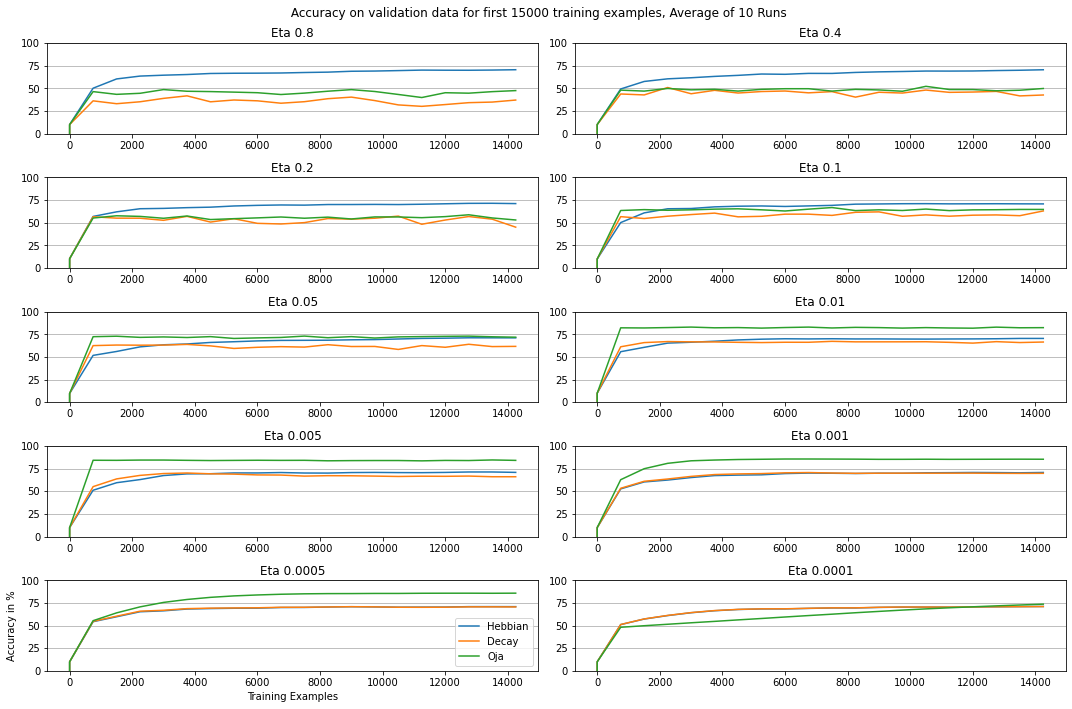

In [16]:
# WARNING: This may take long with small N!
runsLS2 = 10
etas = [0.8, 0.4, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
N_data = 15000
N = 750

assert N_data % N == 0, "N_data needs to be divisible by N"

plt.figure( figsize=( 15, 10 ) )

for i, etaC in enumerate( etas ):
    # Compute Accuracy
    print( f"Eta {i + 1}/{len( etas )}: {etaC}, ", end="" )
    resT, xsT =  accDuringLearning( X_train[:N_data], y_train[:N_data], X_val, y_val, runsLS2, lRs, N, etaC )

    # Average
    avgResT = dict()
    for lR in resT:
        avgResT[lR] = np.average( resT[lR], axis=0 )

    # Plot
    plt.subplot( len( etas ) // 2, 2, i + 1 )
    plt.ylim( [0, 100] )

    for lR in lRs:
        plt.plot( xsT, np.array( avgResT[lR] ) * 100, label=lR )

    # Details
    plt.title( f"Eta {etaC}" )
    plt.grid( True, axis="y" )

    # Legend
    if i == ( len( etas ) - 2 ):
        plt.xlabel( "Training Examples" )
        plt.ylabel( "Accuracy in %" )
        plt.legend( lRs.keys() )

plt.suptitle( f" Accuracy on validation data for first {N_data} training examples, Average of {runsLS2} Runs" )
plt.tight_layout();

It can observed that an eta between 0.01 and 0.001 seem to work the best for all learning rules. Furthermore
It becomes evident that the Oja network outperforms both other networks significantly and from the get-go.

Moreover, all the networks reach their best classification accuracy already after around 10.000 training examples. Thus from now on the learning rate decay will be applied already after 20% of the training data has passed.

### Why do the networks struggle with the 5?

When looking at the prediction accuracy accross numbers the performance for the "5" is astronomically bad. Even the Oja network seems to struggle. But why could that be the case?

To answer this question 3 networks are trained, their results are verified and then a look at their weight distribution is taken.

In [17]:
# Train 3 networks
runs5 = 1
epochs5 = 3
decayAfter5 = 0.2 # Decay weights after 20% of dataset have passed
decay5 = 0.9
eta5 = 0.01

accuracies5, wrongIndices5, _, networks5 = trainNewNetworksAndTest( X_train,
                                                                 y_train,
                                                                 X_val,
                                                                 y_val,
                                                                 X_test,
                                                                 y_test,
                                                                 runs=runs5,
                                                                 epochs=epochs5,
                                                                 learningRules=learningRules,
                                                                 decayAfter=decayAfter5,
                                                                 decay=decay5,
                                                                 permute=True,
                                                                 eta=eta5,
                                                                 retNetworks=True
                                                                )

Run Number 1
Hebb
Epoch 1: Val: 0.7115 Eta: 0.005904900000000002
Epoch 2: Val: 0.7123 Eta: 0.003138105960900002
Epoch 3: Val: 0.7119 Eta: 0.0016677181699666583
Decay
Epoch 1: Val: 0.6585 Eta: 0.005904900000000002
Epoch 2: Val: 0.6517 Eta: 0.003138105960900002
Epoch 3: Val: 0.6600 Eta: 0.0016677181699666583
Oja
Epoch 1: 

<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


Val: 0.8285 Eta: 0.005904900000000002
Epoch 2: Val: 0.8383 Eta: 0.003138105960900002
Epoch 3: Val: 0.8562 Eta: 0.0016677181699666583
Done


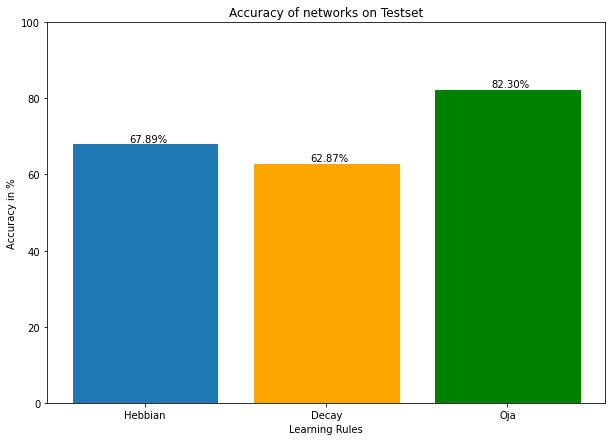

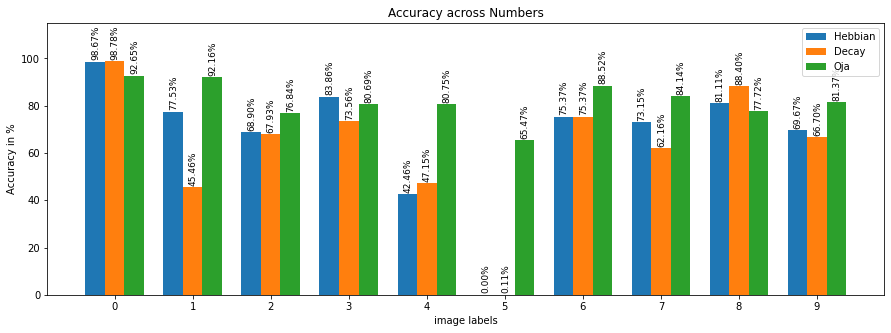

In [18]:
# Verify the accuracy on testset
plotAccuracies( [ v[0] for v in accuracies5.values() ],
             learningRuleNames,
             "Accuracy of networks on Testset"
            )

plotNumberAccFromWrong( y_test,
                       wrongIndices5,
                       0,
                       "Accuracy across Numbers"
                      )

It can be seen that the results of the networks are normal. Now the weights are visualized:

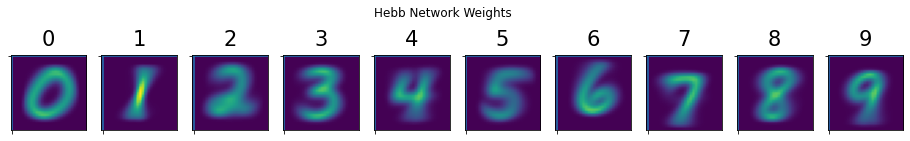

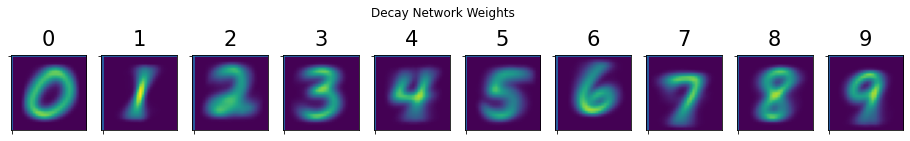

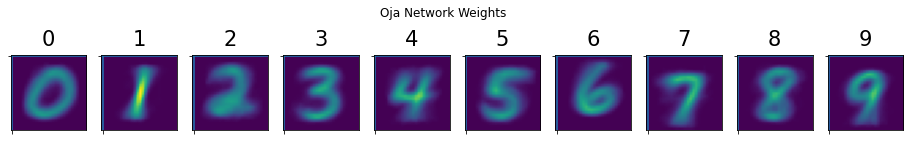

In [19]:
plotWeights( networks5['hebb'][0].getWeights() )
plt.suptitle( "Hebb Network Weights" )
plotWeights( networks5['deca'][0].getWeights() )
plt.suptitle( "Decay Network Weights" )
plotWeights( networks5['ojas'][0].getWeights() )
plt.suptitle( "Oja Network Weights" );

The weights almost look identical!

This can be explained by python automatically scaling the picture values to the maximum and minimum value, thus the results from above mean that the ratio of weights is very similar to each other, still the learnt weights are quite different as it can be seen with their maxima:

In [20]:
print( f"Hebb Max: {np.max( networks5['hebb'][0].getWeights() )}" )
print( f"Decay Max: {np.max( networks5['deca'][0].getWeights() )}" )
print( f"Oja Max: {np.max( networks5['ojas'][0].getWeights() )}" )

Hebb Max: 89.28492458104256
Decay Max: 0.9647672105402134
Oja Max: 0.17492339340738508


But if the weight ratios are so similar, why is the prediction accuracy so much better for the Oja network?

We can see that there is no certain pattern besides the prediction of "0","3","8" and "9" in the missclassification of the other two networks when attempting to label the 5:

In [21]:
h, d, o = copy.copy( networks5['hebb'][0] ), copy.copy( networks5['deca'][0] ), copy.copy( networks5['ojas'][0] )

In [22]:
examples = 5
os = random.randint( 0, len( numsLabels[5] ) - examples )
for i in range( examples ):
    print( "###")
    print( f"True Label: { np.argmax( numsLabels[5][i + os] )}")
    print( f"Hebb Prediction: {np.argmax( softmax( h.compute( numsData[5][i + os] ) ) )}" )
    print( f"Decay Prediction: {np.argmax( softmax( d.compute( numsData[5][i + os] ) ) )}" )
    print( f"Ojas Prediction: {np.argmax( softmax( o.compute( numsData[5][i + os] ) ) )}" )

###
True Label: 5
Hebb Prediction: 8
Decay Prediction: 8
Ojas Prediction: 5
###
True Label: 5
Hebb Prediction: 3
Decay Prediction: 3
Ojas Prediction: 3
###
True Label: 5
Hebb Prediction: 3
Decay Prediction: 3
Ojas Prediction: 3
###
True Label: 5
Hebb Prediction: 3
Decay Prediction: 3
Ojas Prediction: 5
###
True Label: 5
Hebb Prediction: 3
Decay Prediction: 3
Ojas Prediction: 5


The key factor is the normalization! If the weights of the Hebb and Decay network are normalized, they reach a similar accuracy to the Oja network.

In [23]:
print( "Accuracy before normalization" )
print( f" Hebb Accuracy on testset  {runTest( X_test, y_test, h )[0] * 100:.2f}%")
print( f" Decay Accuracy on testset {runTest( X_test, y_test, d )[0] * 100:.2f}%")
print( f" Oja Accuracy on testset   {runTest( X_test, y_test, o )[0] * 100:.2f}%")
h.weights = normalizeRows( h.weights )
d.weights = normalizeRows( d.weights )
print( "\nAccuracy after normalization" )
print( f" Hebb Accuracy on testset  {runTest( X_test, y_test, h )[0] * 100:.2f}%")
print( f" Decay Accuracy on testset {runTest( X_test, y_test, d )[0] * 100:.2f}%")
print( f" Oja Accuracy on testset   {runTest( X_test, y_test, o )[0] * 100:.2f}%")

Accuracy before normalization
 Hebb Accuracy on testset  67.89%
 Decay Accuracy on testset 62.87%
 Oja Accuracy on testset   82.30%

Accuracy after normalization
 Hebb Accuracy on testset  82.36%
 Decay Accuracy on testset 82.25%
 Oja Accuracy on testset   82.30%


This effect is partly due to the distribution of numbers in the training data. The amount of training images with "5" is the lowest, thus the weights in the neuron responsible for the "5" are a lot lower compared to the weights in other neurons. This leads to a higher activation of other neurons because a few shared neurons have an activation which is combined higher then all shared neurons of the "5" together. If you look closely at the visualized weights, you can see that the 5 in the Hebb and Decay Network is less "active" than the other numbers, whereas in the Oja network all numbers except of "1" are similar.

But even with an evenly distributed testset it is to be expected that there will be some disproportionate activation of Neurons in the Hebb and Decay network. For example if there are many images in the training data in which the "8" is shifted a bit to the left, if a "5" in the test data is also shifted to the left then the weights of the "8" may be enough to disproportionatly activate the "8" neuron. Thus the "5" gets misclassified as "8".

## Detour: Oja and Decay network

As a short detour it should be noted, that in context of this dataset the Oja and Decay learning rule behave the same way if the normalization is not taken into account. This effect is the result of most pixel values (data points) being either close to zero or to one, as most of the pixels are white (0), some are black (1), but they are rarely in between:

In [24]:
e = 0.05
n = 0
for x in X_train:
    n += ( x[x < e].shape[0] + x[x > (1 - e)].shape[0] ) / ( 28 * 28 )
print( f"{n * 100 / X_train.shape[0]:.2f}% of datapoints are within {e} range of 0 or 1")

89.67% of datapoints are within 0.05 range of 0 or 1


When looking at the at the learning rules it becomes evident that for close to 0 and close to 1 values the learning rules in essence behave the same, as $\mathbf{y}$ is the only difference in between them:

Decay:
\begin{equation}
\mathbf{\hat{W}} = \mathbf{W} + \eta \mathbf{y}( \mathbf{x} - \mathbf{W} )
\end{equation}

Oja:
\begin{equation}
\mathbf{\hat{W}} = \mathbf{W} + \eta \mathbf{y}( \mathbf{x} - \mathbf{y} \mathbf{W} )
\end{equation}

## Final Training

With all the information of the sections above, three new networks are trained multiple times on an evenly distributed dataset to draw a final conclusion.

First, an evenly distributed dataset is created and plotted to make sure it looks good.

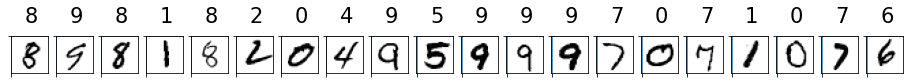

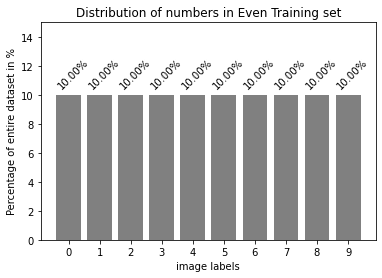

In [25]:
# Create evenly distributed dataset:
length_even = 10 * min( [ len(x) for x in numsLabels ] )
X_even = np.zeros( (length_even, X_train.shape[1] ) )
y_even = np.zeros( (length_even, y_train.shape[1] ) )

s = min( [ len(x) for x in numsLabels ] )
for i in range( 10 ):
    X_even[i * s:( i + 1 ) * s] = numsData[i][:s]
    y_even[i * s:( i + 1 ) * s] = numsLabels[i][:s]

# plot it to make sure it looks good
plotData( X_even, y_even, 20 )
plotDistribution( y_even, "Distribution of numbers in Even Training set" )

Now networks are trained one last time for the result section!

In [26]:
# Train one last time with all learnings incorporated! This takes ~5-10 mins
runs = 10
epochs = 5
decayAfter = 0.1
decay = 0.95
eta = 0.001

accuracies, wrongIndices, _, networks = trainNewNetworksAndTest( X_even,
                                                                 y_even,
                                                                 X_val,
                                                                 y_val,
                                                                 X_test,
                                                                 y_test,
                                                                 runs=runs,
                                                                 epochs=epochs,
                                                                 learningRules=learningRules,
                                                                 decayAfter=decayAfter,
                                                                 decay=decay,
                                                                 permute=True,
                                                                 eta=eta,
                                                                 retNetworks=True
                                                                )

Run Number 1
Hebb
Epoch 1: Val: 0.6648 Eta: 0.0005987369392383785
Epoch 2: Val: 0.6648 Eta: 0.0003405616262881147
Epoch 3: Val: 0.6656 Eta: 0.00019371148445850077
Epoch 4: Val: 0.6654 Eta: 0.00011018311023500519
Epoch 5: Val: 0.6654 Eta: 6.267216326897829e-05
Decay
Epoch 1: Val: 0.6646 Eta: 0.0005987369392383785
Epoch 2: Val: 0.6617 Eta: 0.0003405616262881147
Epoch 3: Val: 0.6613 Eta: 0.00019371148445850077
Epoch 4: Val: 0.6615 Eta: 0.00011018311023500519
Epoch 5: Val: 0.6621 Eta: 6.267216326897829e-05
Oja
Epoch 1: 

<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


Val: 0.8646 Eta: 0.0005987369392383785
Epoch 2: Val: 0.8554 Eta: 0.0003405616262881147
Epoch 3: Val: 0.8592 Eta: 0.00019371148445850077
Epoch 4: Val: 0.8569 Eta: 0.00011018311023500519
Epoch 5: Val: 0.8579 Eta: 6.267216326897829e-05
Run Number 2
Hebb
Epoch 1: Val: 0.6640 Eta: 0.0005987369392383785
Epoch 2: Val: 0.6640 Eta: 0.0003405616262881147
Epoch 3: Val: 0.6648 Eta: 0.00019371148445850077
Epoch 4: Val: 0.6640 Eta: 0.00011018311023500519
Epoch 5: Val: 0.6637 Eta: 6.267216326897829e-05
Decay
Epoch 1: Val: 0.6646 Eta: 0.0005987369392383785
Epoch 2: Val: 0.6592 Eta: 0.0003405616262881147
Epoch 3: Val: 0.6631 Eta: 0.00019371148445850077
Epoch 4: Val: 0.6621 Eta: 0.00011018311023500519
Epoch 5: Val: 0.6619 Eta: 6.267216326897829e-05
Oja
Epoch 1: Val: 0.8625 Eta: 0.0005987369392383785
Epoch 2: Val: 0.8592 Eta: 0.0003405616262881147
Epoch 3: Val: 0.8560 Eta: 0.00019371148445850077
Epoch 4: Val: 0.8615 Eta: 0.00011018311023500519
Epoch 5: Val: 0.8581 Eta: 6.267216326897829e-05
Run Number 3


For the learning speed comparison the networks are trained with same parameters (but only for 3 epochs) and evaluated all 3000 training examples.

In [27]:
# Warning! this takes ~ 8 - 15 mins
stepSize = 3000
epochsOverride = 3

resultsLS, xsLS, offsetLS = accDuringTrainingEpochs( X_train,
                                              y_train,
                                              X_val,
                                              y_val,
                                              runs,
                                              epochsOverride,
                                              lRs,
                                              stepSize,
                                              eta=eta,
                                              decay=decay
                                             )

Run 0
--Epoch 1
+

<ipython-input-1-724e6dea6728>:18: RuntimeWarning: invalid value encountered in true_divide
  return x / np.linalg.norm( x, axis=1 )[ :, None ]


+++++++++
--Epoch 2
++++++++++
--Epoch 3
++++++++++
Run 1
--Epoch 1
++++++++++
--Epoch 2
++++++++++
--Epoch 3
++++++++++
Run 2
--Epoch 1
++++++++++
--Epoch 2
++++++++++
--Epoch 3
++++++++++
Run 3
--Epoch 1
++++++++++
--Epoch 2
++++++++++
--Epoch 3
++++++++++
Run 4
--Epoch 1
++++++++++
--Epoch 2
++++++++++
--Epoch 3
++++++++++
Run 5
--Epoch 1
++++++++++
--Epoch 2
++++++++++
--Epoch 3
++++++++++
Run 6
--Epoch 1
++++++++++
--Epoch 2
++++++++++
--Epoch 3
++++++++++
Run 7
--Epoch 1
++++++++++
--Epoch 2
++++++++++
--Epoch 3
++++++++++
Run 8
--Epoch 1
++++++++++
--Epoch 2
++++++++++
--Epoch 3
++++++++++
Run 9
--Epoch 1
++++++++++
--Epoch 2
++++++++++
--Epoch 3
++++++++++


In [28]:
# Average the accuracies
avgAccsFinal = dict()
for network in accuracies.keys():
    avgAccsFinal[network] = np.average( accuracies[network] )

# Average results of learning speed comparison
avgResultsLS = dict()
for lR in resultsLS:
    avgResultsLS[lR] = np.average( resultsLS[lR], axis=0 )

# Stage 3: Conclusion

Now that everything is defined and the architectures are explored, let's discuss the results regarding following three points:

1. Which model has a higher classification accuracy?
2. Which model learns faster?
3. Interesting other effects

### Accuracy

In this section the clear winner is the Oja network. With a balanced testset, the Decay and plain Hebb learning rule lead to the same classification accuracy. However, it should be kept in mind that the plain Hebb learning rule is inpractical in practice due to its weight explosion.

The lead of the Oja learning rule compared to the others is mainly due to the normalization of weights. As seen, the Hebb and Decay network reach the same classification accuracy as the Oja network after the normalization of their weights. This is because the normalization of weights makes sure that no neuron activates inproportionatly much because of a few Neurons with extremely high weights.

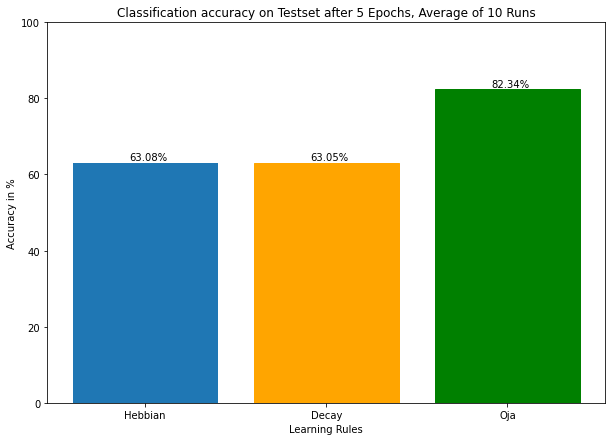

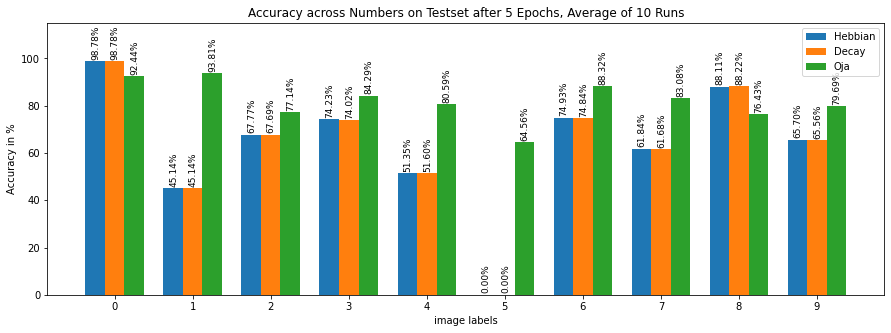

In [29]:
plotAccuracies( avgAccsFinal.values(), learningRuleNames, f"Classification accuracy on Testset after {epochs} Epochs, Average of {runs} Runs" )
plotAvgNumberAccFromWrong( y_test, wrongIndices, f"Accuracy across Numbers on Testset after {epochs} Epochs, Average of {runs} Runs" )

### Learning speed

As in the section before, the Oja network outperforms both other networks. And that directly from the get go of training. Since the Oja network without normalization and Decay network would perform very similar, the lead of the Oja network also can be attributed to normalization.

It should be noted that the Decay networks at first seems to learn faster then the Hebbian network, but after that its accuracy decreases again. This effect could be interesting to explore.

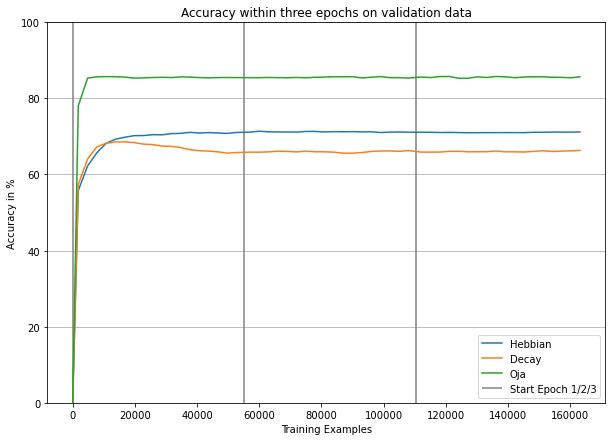

In [30]:
# Plot results
plotLineGraph( avgResultsLS, "Accuracy within three epochs on validation data", "Training Examples", "Accuracy in %", lRs, stepSize, offsetLS, xsLS, False )
plt.vlines( 0, 0, 100, color="grey", label="Start Epoch 1/2/3" )
for i in range( 1, epochsOverride ):
    plt.vlines( X_train.shape[0] * i, 0, 100, color="grey" )
plt.legend( loc='lower right' );

### Emerging other effects

Again, the Oja learning rule clearly wins. Due to its properties the weights of the Neurons converge to an eigenvector of the covariance matrix of the input data - which is the first principle component of the data (Oja 1982). This could be very helpful for further image analysis, for instance, finding which pixels are the most important ones, but also could lead to interesting effects in a biological system inheriting such traits. An example could be that through this method the biological system has (mathematically accurate!) methods to assess the importance of certain aspects in the input data.

A visualization of the resulting PCA eigenvector can be seen below, in which bright pixels indicate a higher explanation of variance in the corresponing pixel.

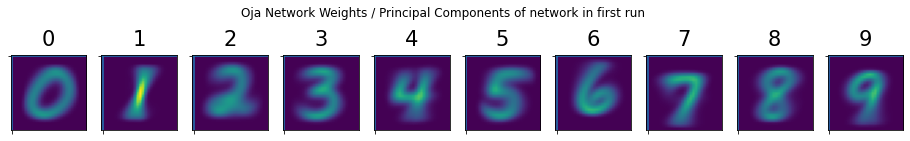

In [31]:
plotWeights( networks['ojas'][0].getWeights() )
plt.suptitle( "Oja Network Weights / Principal Components of network in first run" );

## Conclusion: How do Neural Networks learning with the plain Hebb rule, Hebb-Decay rule and Oja rule respectively compare to each other regarding accuracy, learning speed and other features in a digit classification task?

The Oja learning rule beats both other learning rules significantly in every category. It does not only learn faster, but also classifies digits more accuractly with a difference close to 20%. In this 10-way digit classification task, this is mainly due to the normalization, because of which the classification accuracy significantly improves. Furthermore the properties of the Oja network lead to the additional effect of performing an approximate PCA.

Still, in comparison to the state of the art classification methods the Oja network is long shot away. Furthermore the visualization of weights shows that the network very likely will not generalize at all - for example a 1 which is shifted to the left will probably not be classified correctly. This is in contrast to new state of the art networks, which due to convolutional layers may generalize better.
It would be interesting to explore whether a multi-layer structure could be feasibly implemented without violating biological principles and if that would have a positive effect on classification accuracy.

## Future Work

There is many interesting things to have a longer look at:

- Why does the Decay rule decrease in its classification accuracy?
- How would a spiking neural network with the same learning rules do, compared to the models shown here.
- Is there an effective way to incorporate and train intermediate layers?
- How would a convoutional architecture perform?
- How would recurrance affect the prediction accuracy?
- How would a competetive structure affect accuracy?
- What would happen for all-connected networks?
- Besides the PCA, is there other emerging factors?

# References

Amato, G., Carrara, F., Falchi, F., Gennaro, C., & Lagani, G.(2019). Hebbian Learning Meets Deep Convolutional Neural Networks. In: Ricci E., Rota Bulò S., Snoek C., Lanz O., Messelodi S., Sebe N. (eds) Image Analysis and Processing – ICIAP 2019. ICIAP 2019. Lecture Notes in Computer Science, vol 11751. Springer, Cham. https://doi.org/10.1007/978-3-030-30642-7_29

LeCun, Y., Cortes, C., & Burges, C.J.C., The MNIST Database of Handwritten Digits \[Accessed 26.11.2020 18:00 CET\]. http://yann.lecun.com/exdb/mnist/

Morris R. G. (1999). D.O. Hebb: The Organization of Behavior, Wiley: New York; 1949. Brain research bulletin, 50(5-6), 437. https://doi.org/10.1016/s0361-9230(99)00182-3

Oja, E. (1982). Simplified neuron model as a principal component analyzer. In: J. Math. Biology 15, 267–273. https://doi.org/10.1007/BF00275687

Serre, T., Oliva, A., &amp; Poggio, T. (2007). A feedforward architecture accounts for rapid categorization. Proceedings of the National Academy of Sciences, 104(15), 6424-6429. doi:10.1073/pnas.0700622104

Yamins, D. L., Hong, H., Cadieu, C. F., Solomon, E. A., Seibert, D., &amp; Dicarlo, J. J. (2014). Performance-optimized hierarchical models predict neural responses in higher visual cortex. Proceedings of the National Academy of Sciences, 111(23), 8619-8624. doi:10.1073/pnas.1403112111